In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from time import time

import numpy as np
import pandas as pd
import xarray as xr
from sklearn.linear_model import LinearRegression
from scipy import signal
import xrscipy.signal as dsp

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from cmocean import cm
import hvplot.xarray

import gsw

from niwtools.tools import *
from niwtools.qc import *
from epsilon_tools import *

import warnings
warnings.simplefilter("ignore",category=FutureWarning)
warnings.simplefilter("ignore",category=RuntimeWarning)

purp = pd.read_pickle('../data/purp_colormap.pkl')
# set up figure params
sns.set(style='ticks', context='notebook', palette='colorblind', font_scale=1.3)
mpl.rc('figure', dpi=100, figsize=[12, 6])
mpl.rc('savefig', dpi=500, bbox='tight')
mpl.rc('legend', frameon=False)

xr.set_options(display_style="text", display_width=100,warn_for_unclosed_files=True);

In [92]:
raw = xr.open_dataset('../data/raw_temp.nc')
raw = raw.drop(['lon','lat','pressure'])

## Find b'

In [185]:
raw['b_prime'] = raw.n2.mean('time')*raw.eta.rolling(time=18).mean()

(-200, 0)

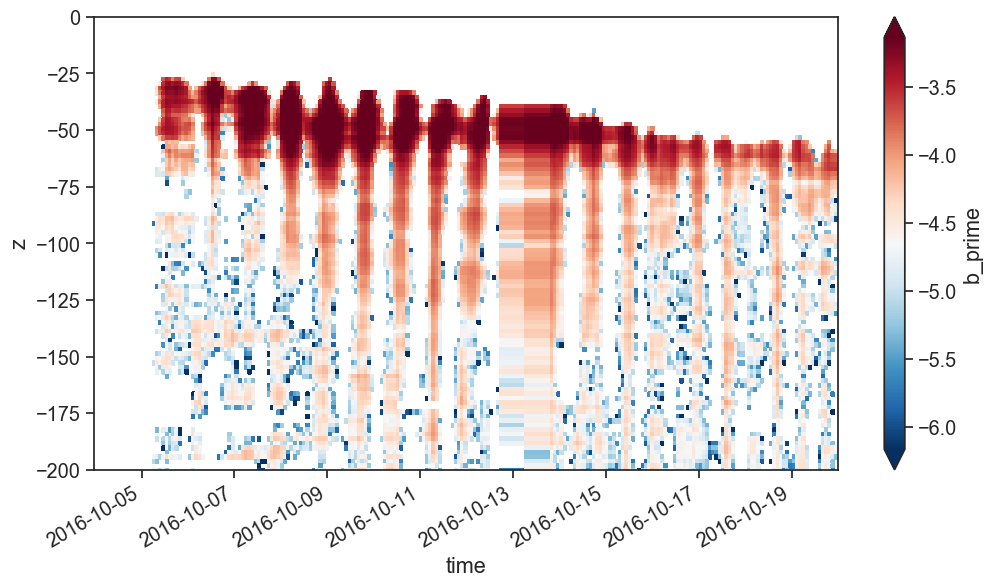

In [186]:
raw.b_prime.pipe(np.log10).plot(robust=True, cmap='RdBu_r')
plt.ylim(-200,0)

## Compute p'

$
b' = N^2\eta \\
p'(z) = \int_z^0 b'dz' - \frac{1}{H}\int_{-H}^0  \int_{z}^0 b'dz'dz
$

In [187]:
tliste=[]
for ti, t in enumerate(raw.time):
    temp = raw.isel(time=ti)
    
    liste=[]
    for zi, z in enumerate( temp.z):
        if temp.b_prime.isel(z=zi).notnull():
            term_a = integral( temp.b_prime, z, 0)
            term_a['z'] = z
            liste.append(term_a)
        else:
            liste.append( np.nan)

    cleanedList = [x for x in liste if type(x)!=float]
    
    if cleanedList:
        new = xr.concat(cleanedList, dim='z')
#         new = new - new.integrate('z')/new.z.max() 

        tliste.append(new)
    
pprime = xr.concat(tliste, dim='time')

In [188]:
tliste=[]
for ti, t in enumerate(pprime.time):
    temp = pprime.isel(time=ti)
    
    term_b = -integral( temp, temp.z.min(), 0)/ temp.z.min()
    tliste.append(term_b)
    
pprime_b = xr.concat(tliste, dim='time')

In [189]:
prime0 = pprime - pprime_b

(-200, 0)

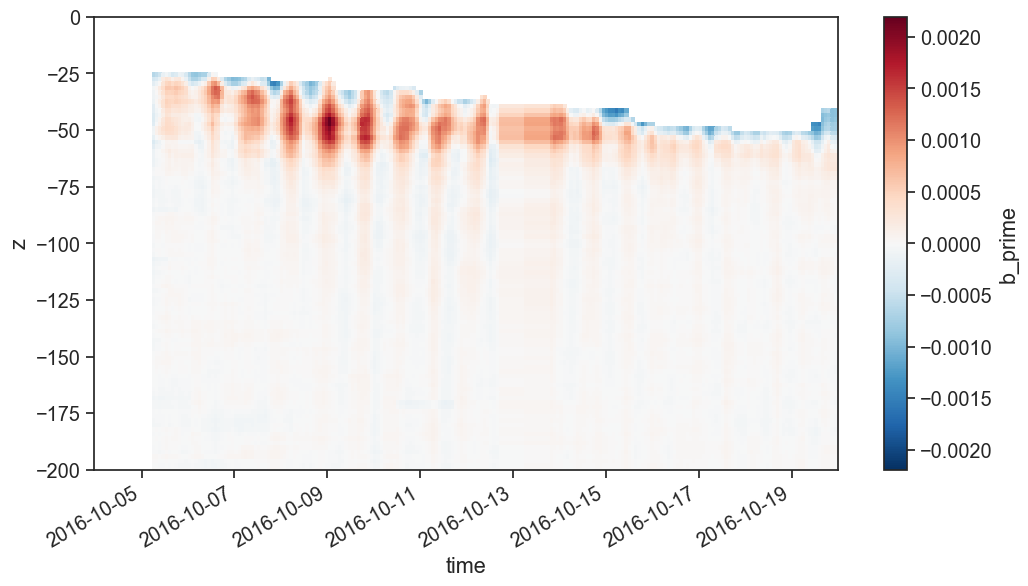

In [190]:
raw.b_prime.plot()
plt.ylim(-200,0)

(-200, 0)

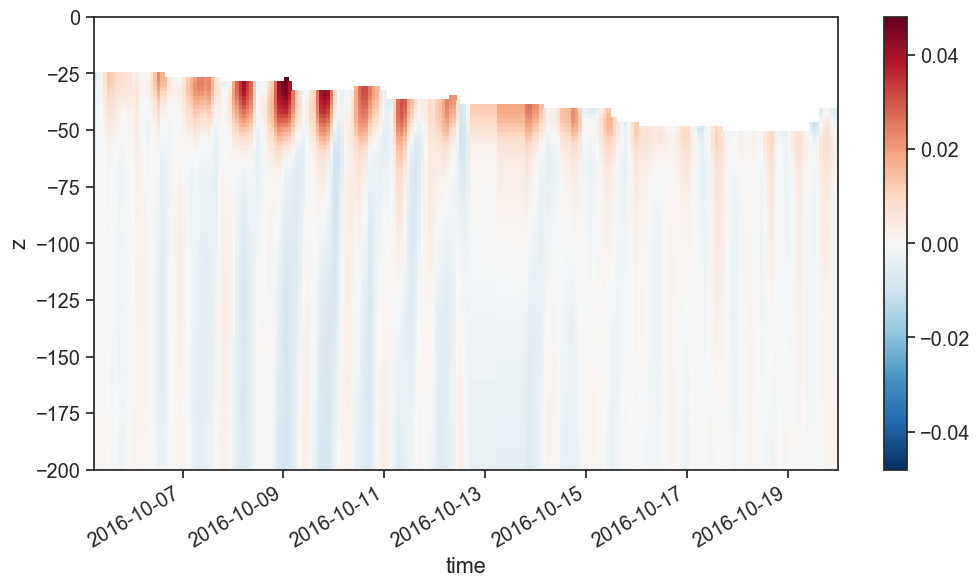

In [191]:
prime0.transpose().plot()
plt.ylim(-200,0)

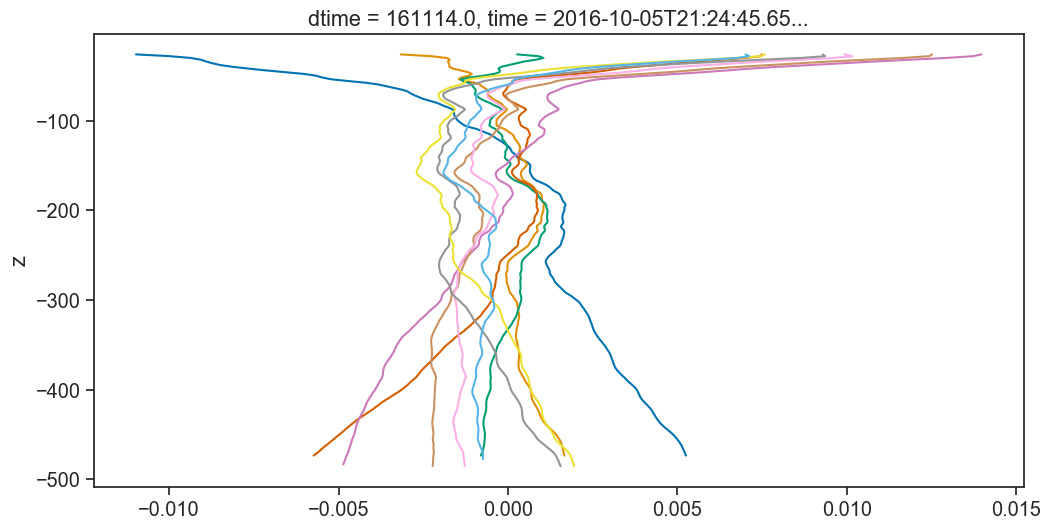

In [201]:
for i in range(10):
    prime0.isel(time=i).plot(y='z')

### Compute u'p'

In [193]:
uprime = raw.uNI
vprime = raw.vNI

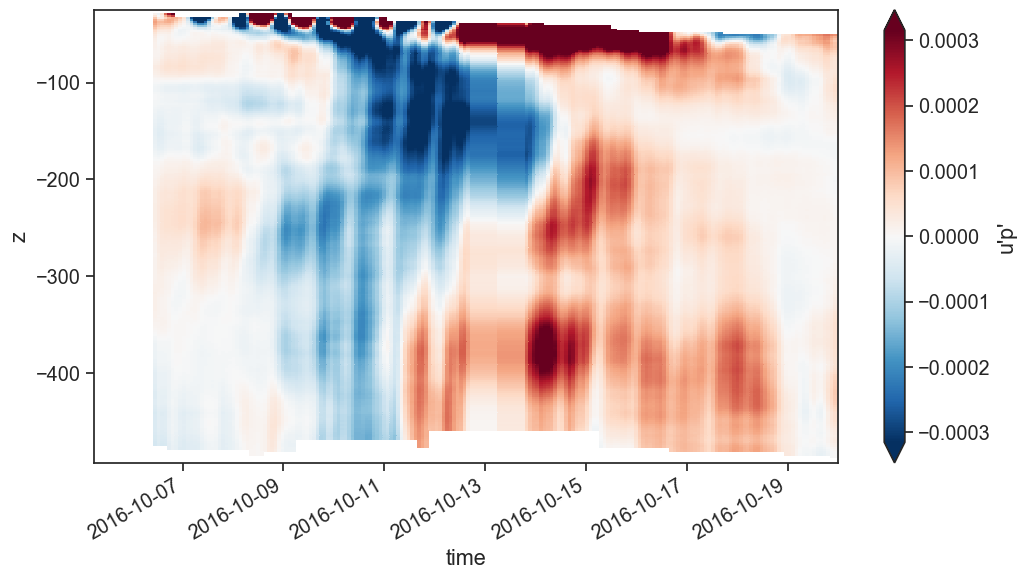

In [202]:
(uprime*prime0).rolling(time=18).mean().plot(robust=True,
                    cbar_kwargs={'label':"u'p'"})

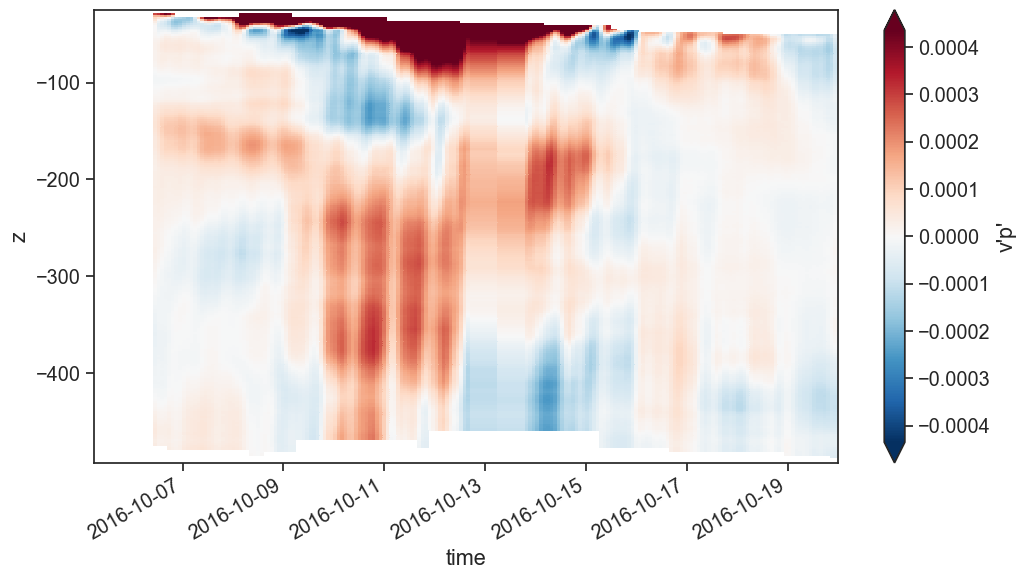

In [203]:
(vprime*prime0).rolling(time=18).mean().plot(robust=True,
                    cbar_kwargs={'label':"v'p'"})

In [222]:
raw['hkeNI'] = raw.hkeNI/1025

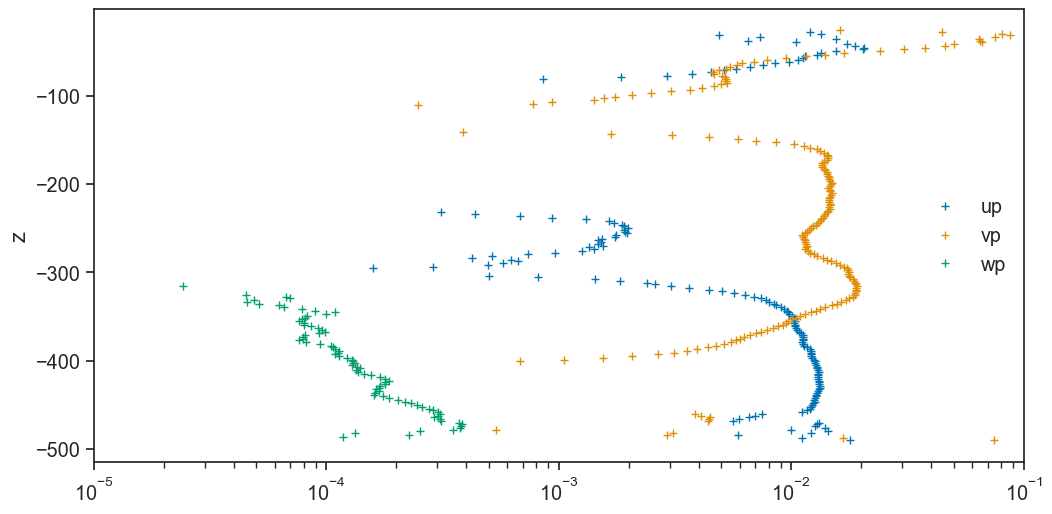

In [232]:
((uprime*prime0)/raw.hkeNI.mean('time')).mean('time').plot(y='z', label='up', marker='+', lw=0)
((vprime*prime0)/raw.hkeNI.mean('time')).mean('time').plot(y='z', label='vp', marker='+', lw=0)
((wprime*prime0)/raw.hkeNI.mean('time')).mean('time').plot(y='z', label='wp', marker='+', lw=0)
plt.xscale('log')
plt.xlim(1e-5,1e-1)
plt.legend()

Text(0.5, 0, 'group speed [m/s]')

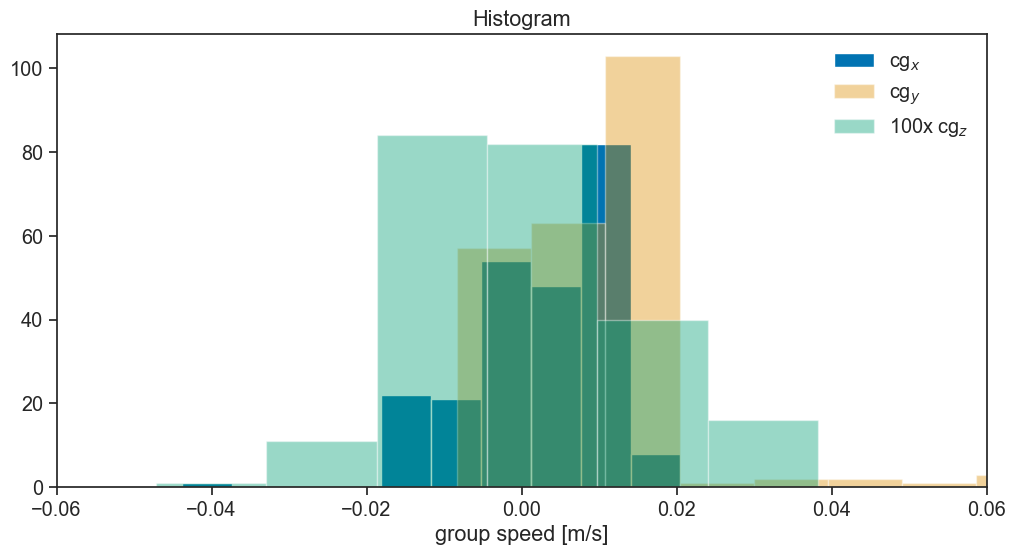

In [272]:
((uprime*prime0)/raw.hkeNI.mean('time')).mean('time').plot.hist(label=r"cg$_x$")
((vprime*prime0)/raw.hkeNI.mean('time')).mean('time').plot.hist(alpha=0.4,label=r"cg$_y$")
((wprime*prime0)/raw.hkeNI.mean('time')).mean('time').pipe(lambda x: x*100).plot.hist(alpha=0.4,label=r"100x cg$_z$")
# plt.xscale('log')
plt.xlim(-0.06,0.06)
plt.legend()
plt.xlabel('group speed [m/s]')

In [234]:
cg = 1e-2
beta = 1/500
f = gsw.f(40.3)

In [238]:
(-cg*beta*0.5 - np.sqrt( (cg*beta*0.5)**2 +f**2))/f

-1.1116151184048633

In [239]:
(-cg*beta*0.5 + np.sqrt( (cg*beta*0.5)**2 +f**2))/f

0.8995919391911222

In [251]:
alpha = beta/10000

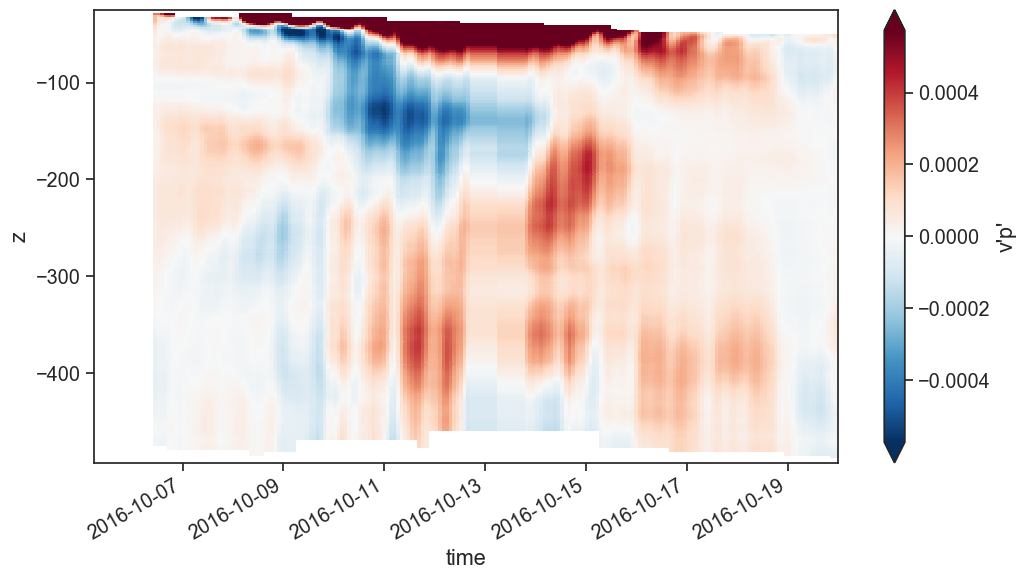

In [208]:
(uprime*prime0 + (vprime*prime0)).rolling(time=18).mean().plot(robust=True,
                    cbar_kwargs={'label':"v'p'"})

### Compute w'

In [197]:
wprime = raw.eta.differentiate('time', datetime_unit='s')

(-500, 0)

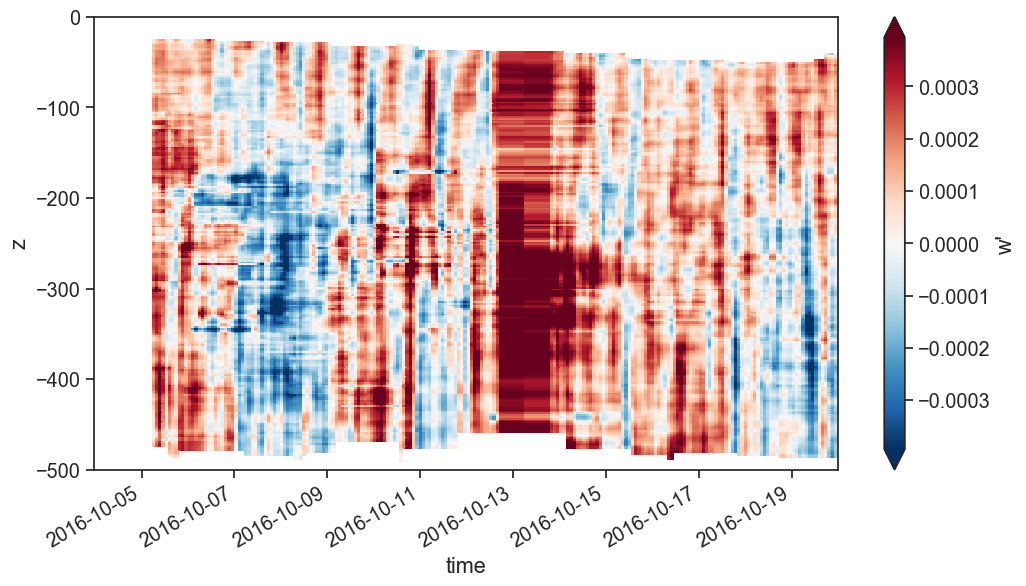

In [198]:
wprime.rolling(time=18).mean().plot(robust=True,
                    cbar_kwargs={'label':"w'"})
plt.ylim(-500,0)

In [206]:
(wprime*prime0).min()

<xarray.DataArray ()>
array(-6.18189405e-05)

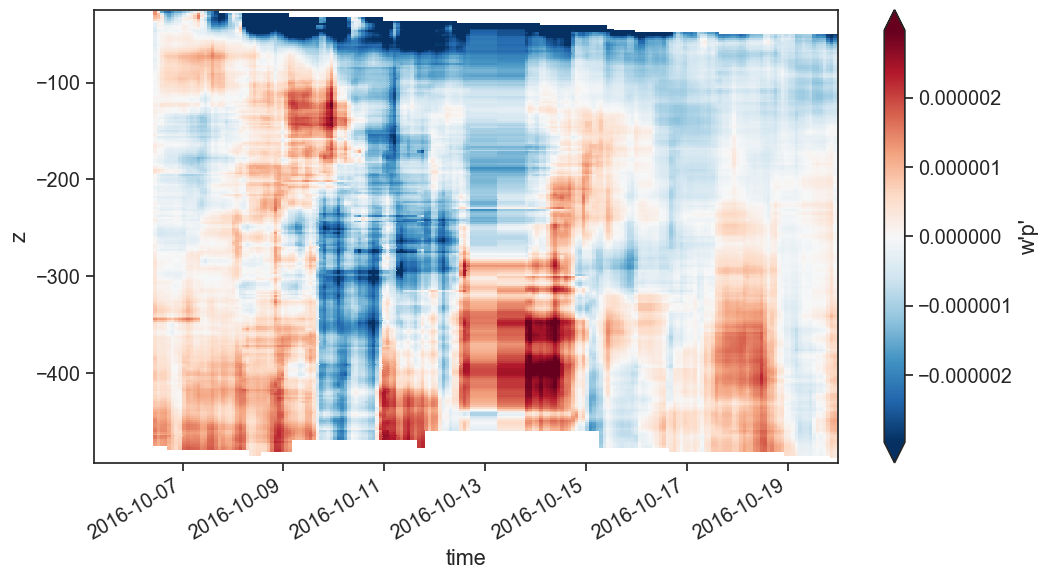

In [205]:
(wprime*prime0).rolling(time=18).mean().plot(robust=True,
                    cbar_kwargs={'label':"w'p'"})

## Spectra of p'

In [273]:
def compute_spectra_zmean(raw,array):
    raw['dtime'] = ('time', np.array( (raw.time - raw.time.isel(time=0)).values*1e-9, dtype=float))
    raw = raw.swap_dims({'time':'dtime'})
    return dsp.spectrogram(raw[array].dropna('z', how='all').mean('z'), dim='dtime',
                           fs=86400/dsp.get_sampling_step(raw, dim='dtime'), nperseg=128 )

def compute_spectra_resid(raw,array):
    raw['dtime'] = ('time', np.array( (raw.time - raw.time.isel(time=0)).values*1e-9, dtype=float))
    raw = raw.swap_dims({'time':'dtime'})
    return dsp.spectrogram(raw[array].dropna('z', how='all')-raw[array].dropna('z', how='all').mean('z'), dim='dtime',
                           fs=86400/dsp.get_sampling_step(raw, dim='dtime'), nperseg=128 )

In [274]:
raw['pprime'] = pprime

In [275]:
S_pprime = compute_spectra(raw, 'pprime').mean('dtime')
S_pprime_zmean = compute_spectra_zmean(raw, 'pprime').mean('dtime')
S_pprime_resid = compute_spectra_resid(raw, 'pprime').mean('dtime')

/Users/sebastianessink/Dropbox (MIT)/niw/src/niwtools/niwtools/tools.py:296: UnevenSamplingWarning: Average sampling 6.43e+03 != first sampling step 9.73e+03
  fs=86400/dsp.get_sampling_step(raw, dim='dtime'), nperseg=128 )
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UnevenSamplingWarning: Average sampling 6.43e+03 != first sampling step 9.73e+03
  """
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UnevenSamplingWarning: Average sampling 6.43e+03 != first sampling step 9.73e+03
  # This is added back by InteractiveShellApp.init_path()


Text(0.5, 0, 'Frequency [cpd]')

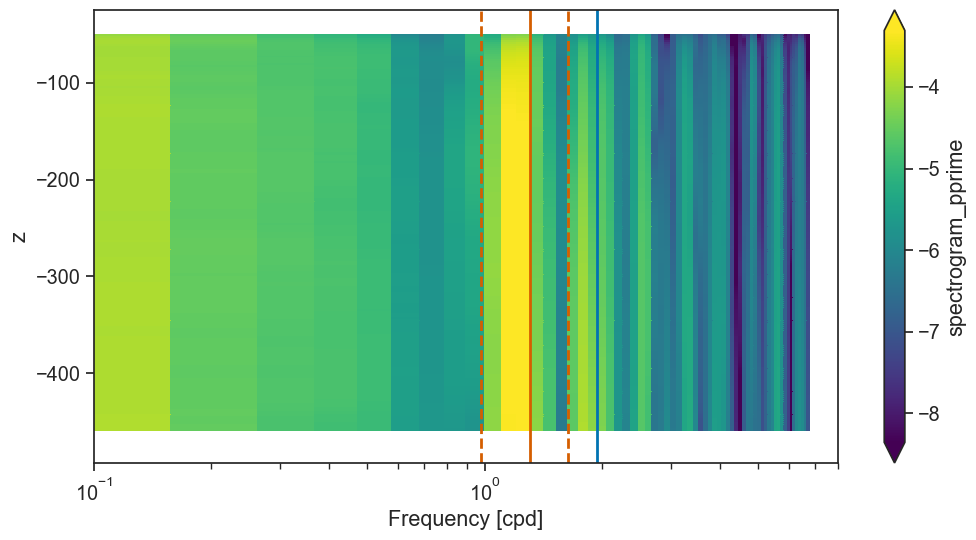

In [280]:
S_pprime.transpose().pipe(np.log10).plot(cmap='viridis', robust=True)
# ax[0].set_ylim(-400,-30)
plt.xlim(1e-1,8e0)
plt.xscale('log')

latmean = 40.7

m2freq = 24/(12+25/60)
plt.axvline(m2freq, lw=2, color='b')
plt.axvline(gsw.f(latmean)*86400/(2*np.pi), lw=2, color='r')
plt.axvline(0.75*gsw.f(latmean)*86400/(2*np.pi), ls='dashed', lw=2, color='r')
plt.axvline(1.25*gsw.f(latmean)*86400/(2*np.pi), ls='dashed', lw=2, color='r')

plt.xlabel('Frequency [cpd]')

Text(0.5, 0, 'Frequency [cpd]')

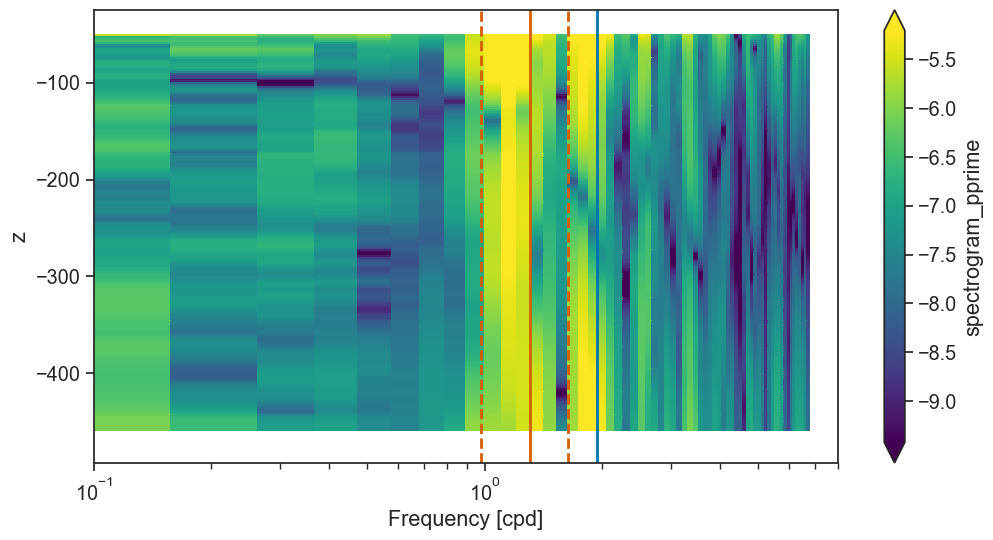

In [282]:
S_pprime_resid.transpose().pipe(np.log10).plot(cmap='viridis', robust=True)
# ax[0].set_ylim(-400,-30)
plt.xlim(1e-1,8e0)
plt.xscale('log')

latmean = 40.7

m2freq = 24/(12+25/60)
plt.axvline(m2freq, lw=2, color='b')
plt.axvline(gsw.f(latmean)*86400/(2*np.pi), lw=2, color='r')
plt.axvline(0.75*gsw.f(latmean)*86400/(2*np.pi), ls='dashed', lw=2, color='r')
plt.axvline(1.25*gsw.f(latmean)*86400/(2*np.pi), ls='dashed', lw=2, color='r')

plt.xlabel('Frequency [cpd]')

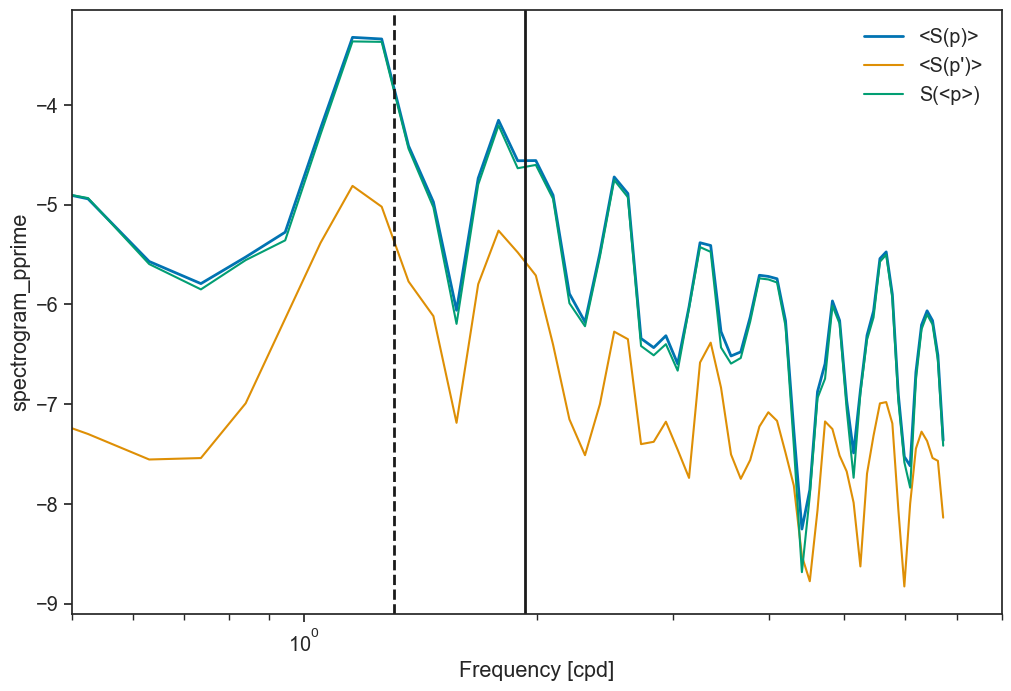

In [288]:
plt.figure(figsize=(12,8))
S_pprime.mean('z').pipe(np.log10).plot(label='<S(p)>', lw=2)
S_pprime_resid.mean('z').pipe(np.log10).plot(label="<S(p')>")
S_pprime_zmean.pipe(np.log10).plot(label=r'S(<p>)')
# plt.ylim(-1,2)
plt.xlim(5e-1,8e0)
plt.xscale('log')

latmean = 40.7

m2freq = 24/(12+25/60)
plt.axvline(m2freq, lw=2, color='k')
plt.axvline(gsw.f(latmean)*86400/(2*np.pi), lw=2, color='k', ls='dashed')
# plt.axvline(0.75*gsw.f(latmean)*86400/(2*np.pi), ls='dashed', lw=2, color='k')
# plt.axvline(1.25*gsw.f(latmean)*86400/(2*np.pi), ls='dashed', lw=2, color='k')

plt.xlabel('Frequency [cpd]')
plt.legend()